El desarrollo de esta práctica consistirá en la evaluación sobre el mismo preprocesamiento de datos datos, aplicando los distintos modelos planteados por Manikanth, M. Gupta, A. Neves 

Para comenzar, el proceso empieza mediante la extracción de los datos y su transformación de modo que tengamos las bases de datos con las imágenes con su respectivo ID y la base de datos con el ID y nueva columna para establecer el la raza de perro. De este modo se tiene que realizar la mezcla entre tablas.

### Extracting and transforming data

In [33]:
import glob
import random
import base64
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
from IPython.display import HTML


from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import numpy as np
import os,cv2,random,time,shutil,csv
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from tqdm import tqdm
import json,os,cv2,keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization,Dense,GlobalAveragePooling2D,Lambda,Dropout,InputLayer,Input
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.preprocessing.image import load_img


from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import tensorflow_hub as hub


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

In [2]:
# paths
path = r'Datasets/'
labels_csv_path = path + 'labels.csv'
sample_submission_csv_path = path + 'sample_submission.csv'
submission_csv_path =  'Datasets/sample_submission.csv'
train_path = path + 'train'
test_path = path + 'test'

number_of_epochs = 10

print(f'Constants are set. Fine tuning takes {number_of_epochs} epochs.')

Constants are set. Fine tuning takes 10 epochs.


In [3]:
labels_df = pd.read_csv(labels_csv_path)
samp_subm = pd.read_csv(submission_csv_path)
print(f'The shape of the labels: {labels_df.shape}')

The shape of the labels: (10222, 2)


In [4]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
print(len(os.listdir(train_path)))

10222


In [6]:
print(len(os.listdir(test_path)))

10357


In [7]:
unique_breeds = pd.unique(labels_df['breed'])
print(len(unique_breeds))

120


In [8]:
each_label = labels_df.groupby("breed").count()
each_label = each_label.rename(columns = {"id" : "count"})
each_label = each_label.sort_values("count", ascending=False)
each_label

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
...,...
golden_retriever,67
brabancon_griffon,67
komondor,67


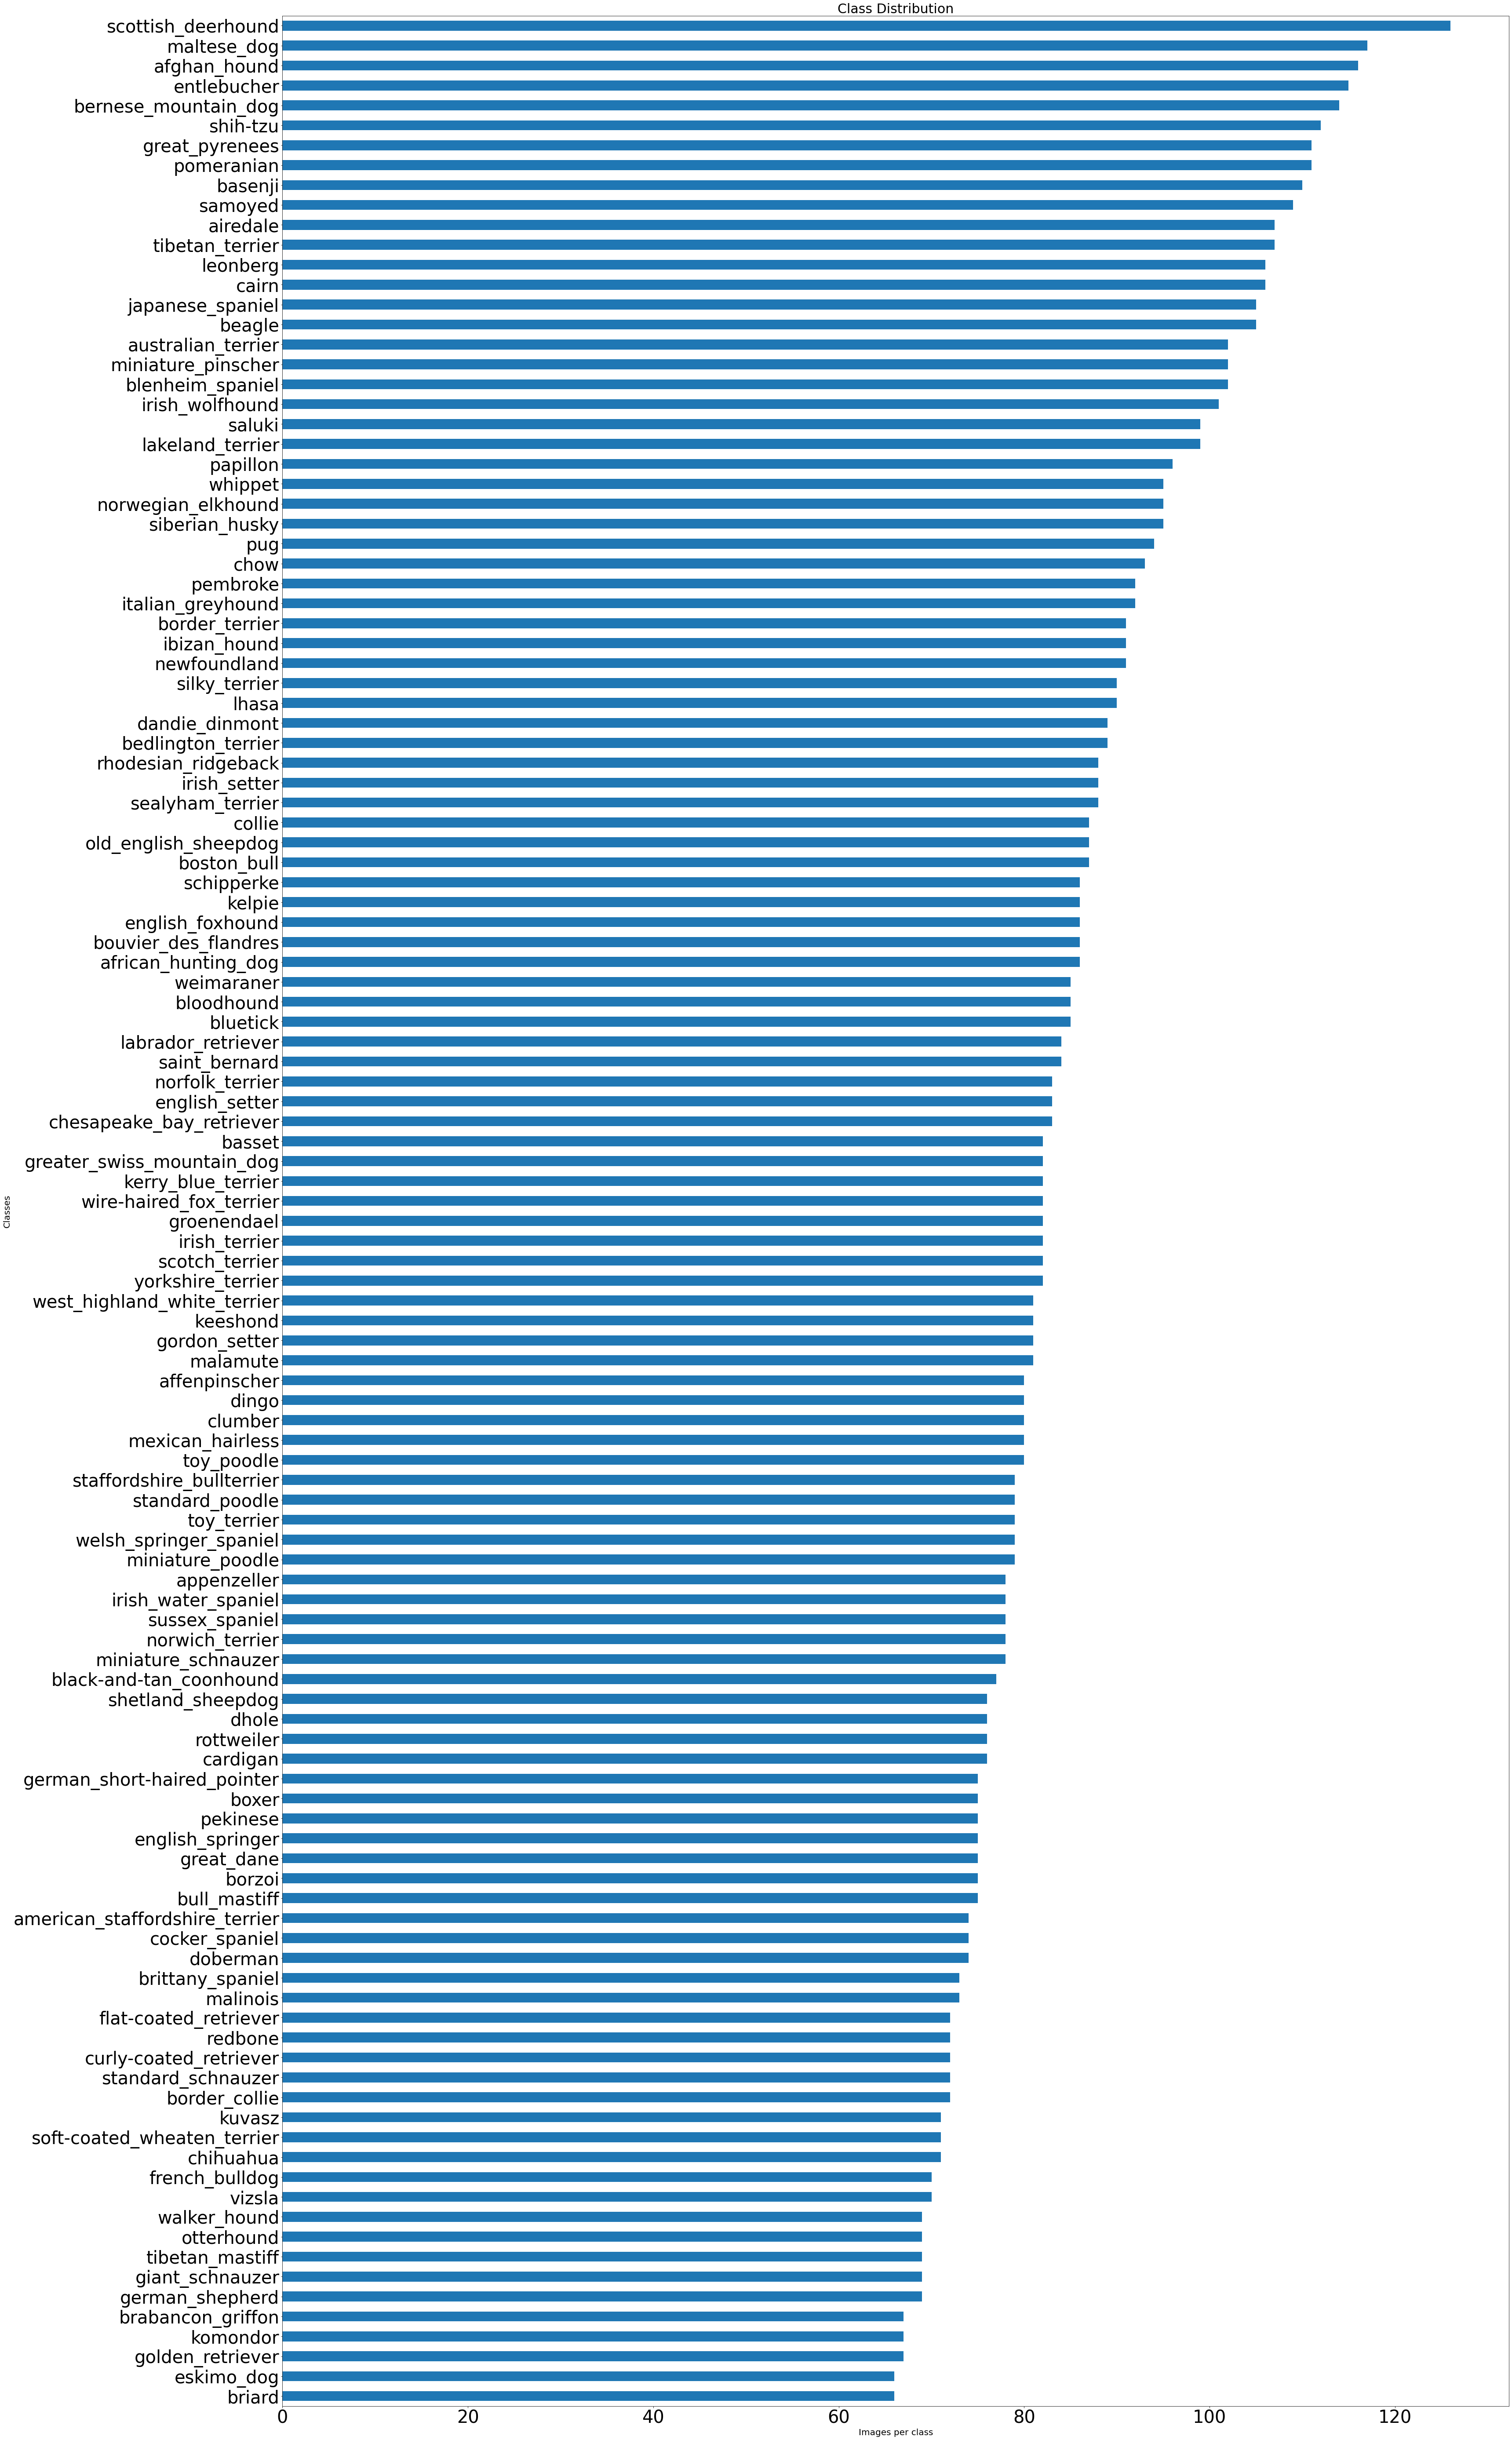

In [12]:
ax=pd.value_counts(labels_df['breed'],ascending=True).plot(kind='barh',
                                                       fontsize="40",
                                                       title="Class Distribution",
                                                       figsize=(50,100))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(30)

In [4]:
pd.set_option('display.max_colwidth', -1)

def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

C:\Users\Enrique\AppData\Local\Temp\ipykernel_8268\1694978098.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [5]:
dogs = pd.read_csv('Datasets/labels.csv')
dogs = dogs.sample(20)
dogs['file'] = dogs.id.map(lambda id: f'Datasets//train/{id}.jpg')
dogs['image'] = dogs.file.map(lambda f: get_thumbnail(f))
dogs.head()

C:\Users\Enrique\AppData\Local\Temp\ipykernel_8268\1694978098.py:5: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  i.thumbnail((150, 150), Image.LANCZOS)


,id,breed,file,image
3235,503695039f80f78a60d6684d553a303f,saluki,Datasets//train/503695039f80f78a60d6684d553a303f.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x150 at 0x2405A393220>
1995,316e8b4fcdc6937baf6680b4596d7d07,west_highland_white_terrier,Datasets//train/316e8b4fcdc6937baf6680b4596d7d07.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x113 at 0x24003E071F0>
5307,85af448e04bc04d107502330ff98ca65,dingo,Datasets//train/85af448e04bc04d107502330ff98ca65.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x87 at 0x24003E072E0>
5328,860e42bbe81a5d30d00bdb77e2c38a80,papillon,Datasets//train/860e42bbe81a5d30d00bdb77e2c38a80.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=149x150 at 0x24003E07340>
475,0b6239db9b1649fe2f513357c82931aa,gordon_setter,Datasets//train/0b6239db9b1649fe2f513357c82931aa.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x113 at 0x24003E073A0>


,breed,image
9594,brabancon_griffon,
6525,tibetan_terrier,
8553,pembroke,
923,groenendael,
8675,basenji,
8647,briard,
7077,sussex_spaniel,
1199,great_pyrenees,
9494,golden_retriever,
1769,saint_bernard,

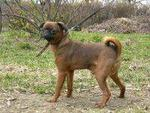
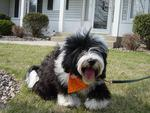
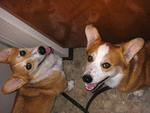
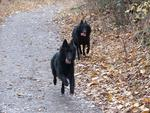
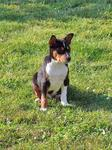
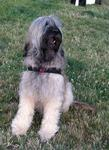
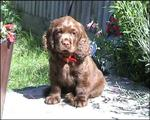
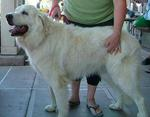
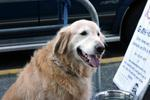
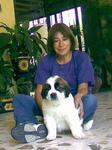
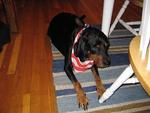
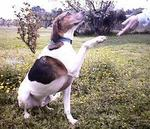
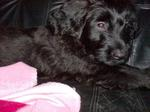
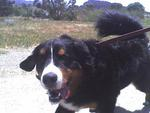
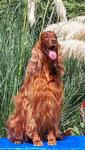
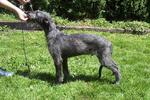
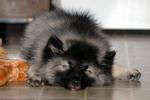
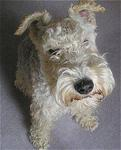
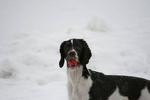
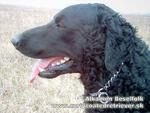

In [11]:
# displaying PIL.Image objects embedded in dataframe
HTML(dogs[['breed', 'image']].to_html(formatters={'image': image_formatter}, escape=False))

Shape: (375, 500, 3)


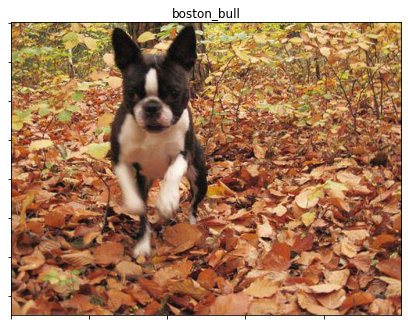

In [12]:
id_ = labels_df.loc[0, 'id']
breed = labels_df.loc[0, 'breed']
file = id_+'.jpg'
img = cv2.imread(path+'train/'+file)
print('Shape:', img.shape)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title(breed)
plt.show()

In [6]:
def plot_examples(category = 'scottish_deerhound'):
    """ Plot 5 images of a given category """
    
    fig, axs = plt.subplots(1, 5, figsize=(25, 20))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    temp = labels_df[labels_df['breed']==category].copy()
    temp.index = range(len(temp.index))
    for i in range(5):
        id_ = temp.loc[i, 'id']
        breed = temp.loc[i, 'breed']
        file = id_+'.jpg'
        img = cv2.imread(path+'train/'+file)
        axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i].set_title(breed)
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
    plt.show()

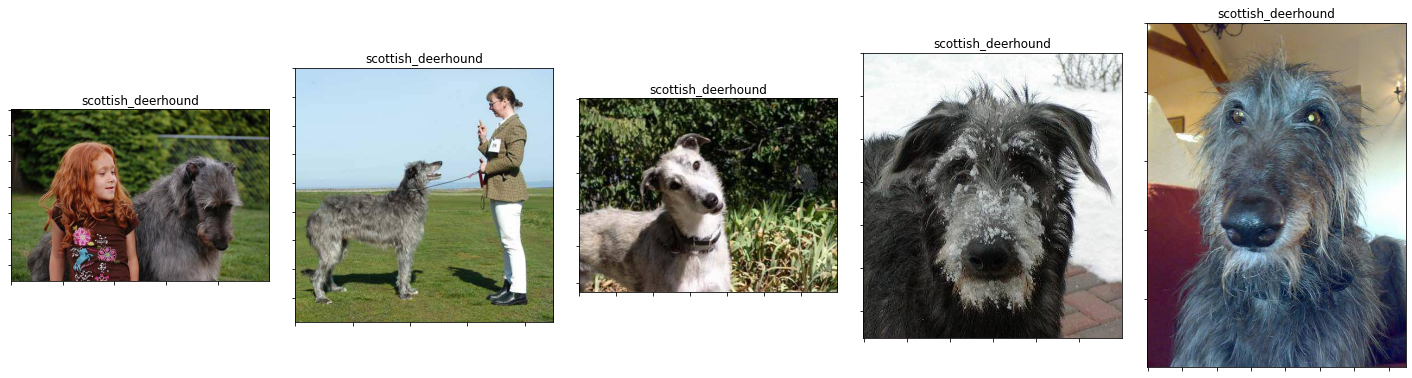

In [7]:
plot_examples()

### Preporcessing data

In [8]:
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
labels_df['breed_label']= label_encoder.fit_transform(labels_df['breed'])
  
labels_df['breed_label'].unique()

array([ 19,  37,  85,  15,  49,  10,  18,   7,  97,  99, 113,  73,  79,
         2, 118,  89,  68,  21,  38,  83, 106,  58,  12,  26,   0,  67,
        55,  40, 114,  48,  54,  36, 110,  17, 109,  80, 100,  57,  66,
        46,  53,   8,   6,  95,  90,  56,   5,  14,  94,  77,  24,  63,
        84,  16,  42,  33,  71, 115,  29,  93,  88,  72,  65,   3,  69,
        74,  25,  11,   4,  70,  27,  60,  31,  96,   1,  82,  92,  75,
        43,  59,  22, 111,  30,  44,  81, 103, 104,  39,  50, 101,  78,
        23,  28,  35,  52,   9, 112, 116,  64, 117,  98, 105,  62,  61,
        76,  87,  34, 119,  86,  51,  13, 102, 107,  47,  45,  20, 108,
        41,  32,  91])

In [9]:
labels_df[labels_df['breed']=='dingo'].head()

,id,breed,breed_label
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37
24,00a338a92e4e7bf543340dc849230e75,dingo,37
43,0120343862761d052d6a7ade81625c94,dingo,37
113,02b1c50fb7315423a664f3ce68c94e30,dingo,37
258,060b163b5ad74c889c47b9f421825cdb,dingo,37


A continuación, se ha realizado una función para realizar el preporcesamiento de los datos. Comenzando por la reasignación de color, pasarlo a escalas de grises y a continuación hacer un recorte para centrar la imagen u realizar un recorte con medidas que se establecen al momento de llamar la función. En nuestro caso estaremos cortando a 64 x 64 pixeles.

In [10]:
def image_preprocessing(image, image_size):

    # cargar información
    readFlag=cv2.COLOR_BGR2GRAY
    image_gray = cv2.cvtColor(image, readFlag)
    
    # cortar imagen
    mid_row = int(image_gray.shape[0]/2)
    mid_col = int(image_gray.shape[1]/2)
    if image_gray.shape[0]>image_gray.shape[1]:
        image_cropped = image_gray[mid_row-mid_col:mid_row+mid_col,
                                   0:image_gray.shape[1]]
    else:
        image_cropped = image_gray[0:image_gray.shape[0],
                                   mid_col-mid_row:mid_col+mid_row]
    # re-escalar imagen
    image_rescale = cv2.resize(image_cropped,
                               dsize=(image_size, image_size),
                               interpolation=cv2.INTER_AREA)
    return image_rescale

def plot_befor_after(image):
    """ comparación con la imgagen original """
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    # Plot Original Image
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('original shape: '+str(image.shape))
    # Image Preprocessing
    image_rescale = image_preprocessing(image, image_size)
    # Plot Prepared Image
    axs[1].imshow(image_rescale, cmap='gray')
    axs[1].set_title('rescaled shape: '+str(image_rescale.shape))
    for i in range(2):
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
    plt.show()    

In [11]:
image_size = 64

Shape: (375, 500, 3)


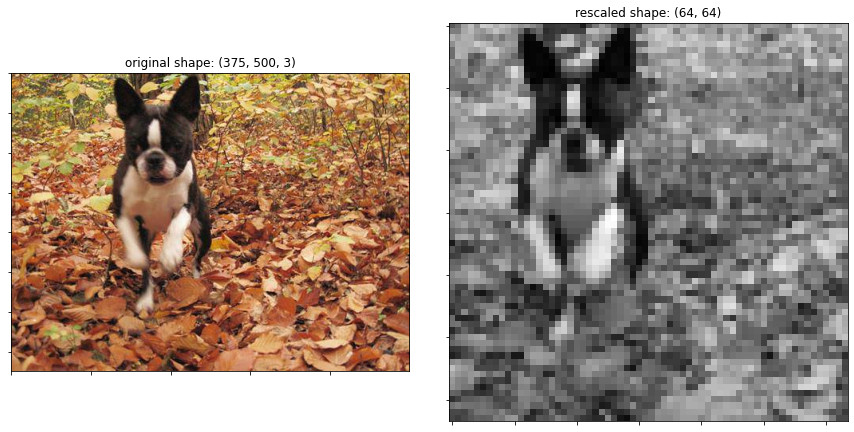

In [12]:
row = 0
id_ = labels_df.loc[row, 'id']
breed = labels_df.loc[row, 'breed']
file = id_+'.jpg'
image = cv2.imread(path+'train/'+file)
print('Shape:', image.shape)
plot_befor_after(image)

Shape: (500, 375, 3)


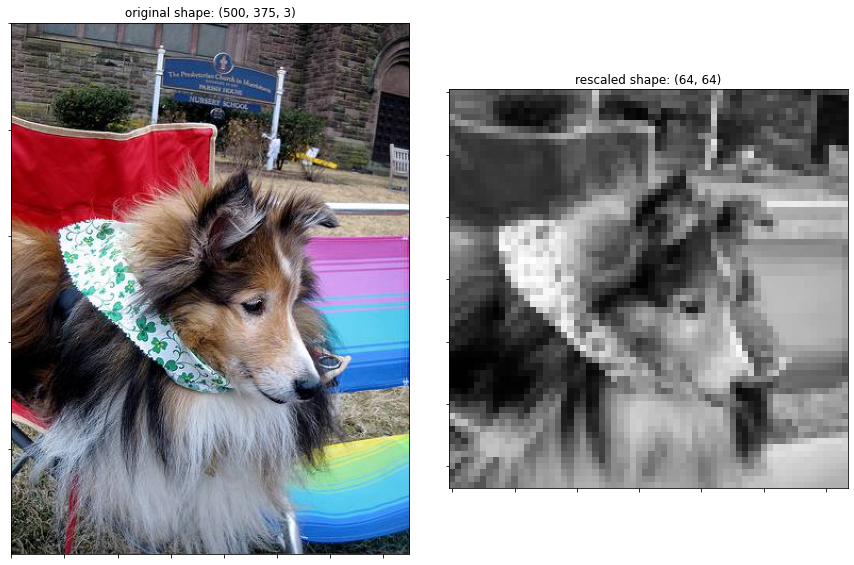

In [13]:
row = 10
id_ = labels_df.loc[row, 'id']
breed = labels_df.loc[row, 'breed']
file = id_+'.jpg'
image = cv2.imread(path+'train/'+file)
print('Shape:', image.shape)
plot_befor_after(image)

Después, se genera un array con los datos preprocesados. De tal modo que se tenga el valor de cada pixel dentro de la escala de grises. Y con dichos resultados se estará generando los sets realizando la división entre las variables independientes y dependientes, respecto a los valores de entrenamiento y de prueba en que el se ocupó una división del 20%.

In [14]:
def prepare_data(path, data, image_size):
    
    X = np.empty((len(data), image_size, image_size), dtype=np.uint8)
    for row in data.index:
        id_ = data.loc[row, 'id']
        file = id_ + '.jpg'
        image = cv2.imread(path+file)
        image_rescaled = image_preprocessing(image, image_size)
        X[row, :, :] = image_rescaled
    X = X.astype('float32')/255
    return X

In [15]:
X_train = prepare_data(path+'train/', labels_df, image_size)
X_test = prepare_data(path+'test/', samp_subm, image_size)

In [16]:
y_train = labels_df['breed']
y_train = pd.get_dummies(y_train)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=2021)

In [60]:
print('Shape train data:', X_train.shape)
print('Shape val data:', X_val.shape)

Shape train data: (8177, 64, 64)
Shape val data: (2045, 64, 64)


In [18]:
X_train = X_train.reshape(-1,image_size,image_size,1)
X_val = X_val.reshape(-1,image_size,image_size,1)
X_test = X_test.reshape(-1,image_size,image_size,1)

In [19]:
X_train = X_train.reshape(-1,image_size,image_size,1)
X_val = X_val.reshape(-1,image_size,image_size,1)
X_test = X_test.reshape(-1,image_size,image_size,1)
print('Shape train data:', X_train.shape)
print('Shape val data:', X_val.shape)

Shape train data: (8177, 64, 64, 1)
Shape val data: (2045, 64, 64, 1)


A continuación, se muestra tres experimentos realizados para el entrenamiento de la red neuronal con diferentes características. Que cabe destacar en los tres se estarán ocupando un algoritmo de optimizador Adam con learning rate de 0.001. Además, estarán siendo evaluados los modelos en su desempeño de la función de pérdida y en la precisión.

### CNN model

In [63]:
CNN_model = Sequential()
CNN_model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (image_size, image_size, 1)))
CNN_model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
CNN_model.add(MaxPool2D(pool_size=(2,2)))
CNN_model.add(Dropout(0.15))


CNN_model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
CNN_model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
CNN_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
CNN_model.add(Dropout(0.15))


CNN_model.add(Flatten())
#model.add(Dense(256, activation = "relu"))
#model.add(Dropout(0.3))
CNN_model.add(Dense(120, activation = "softmax"))

In [64]:
CNN_model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
CNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 16)        416       
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 16)        6416      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        9248      
                                                      

In [66]:
epochs = 15
batch_size = 128


CNN_history = CNN_model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))

Epoch 1/15
64/64 [==============================] - 62s 949ms/step - loss: 4.7870 - accuracy: 0.0100 - val_loss: 4.7766 - val_accuracy: 0.0176
Epoch 2/15
64/64 [==============================] - 57s 899ms/step - loss: 4.7114 - accuracy: 0.0234 - val_loss: 4.6303 - val_accuracy: 0.0289
Epoch 3/15
64/64 [==============================] - 56s 881ms/step - loss: 4.3853 - accuracy: 0.0598 - val_loss: 4.6354 - val_accuracy: 0.0318
Epoch 4/15
64/64 [==============================] - 57s 888ms/step - loss: 3.9968 - accuracy: 0.1114 - val_loss: 4.7621 - val_accuracy: 0.0391
Epoch 5/15
64/64 [==============================] - 55s 868ms/step - loss: 3.3256 - accuracy: 0.2255 - val_loss: 5.2593 - val_accuracy: 0.0396
Epoch 6/15
64/64 [==============================] - 55s 857ms/step - loss: 2.3211 - accuracy: 0.4267 - val_loss: 6.4845 - val_accuracy: 0.0347
Epoch 7/15
64/64 [==============================] - 55s 863ms/step - loss: 1.2706 - accuracy: 0.6731 - val_loss: 8.0820 - val_accuracy: 0.0333

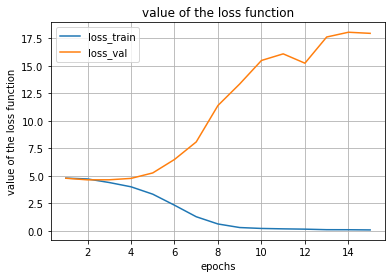

In [67]:
loss = CNN_history.history['loss']
loss_val = CNN_history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='loss_train')
plt.plot(epochs, loss_val, label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

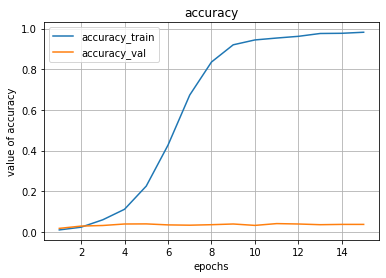

In [68]:
acc = CNN_history.history['accuracy']
acc_val = CNN_history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, label='accuracy_train')
plt.plot(epochs, acc_val,  label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

### CNN model 2

In [85]:
from tensorflow.keras.layers import Dense, Dropout, Flatten

In [101]:
CNN_model_2 = Sequential()
CNN_model_2.add(Conv2D(64,(3,3),input_shape=(64, 64, 1), activation = 'relu'))
CNN_model_2.add(MaxPool2D(pool_size=(2,2)))
CNN_model_2.add(Conv2D(32,(3,3), activation = 'relu'))
CNN_model_2.add(MaxPool2D(pool_size=(2,2)))
CNN_model_2.add(Conv2D(16,(3,3), activation = 'relu'))
CNN_model_2.add(Conv2D(8,(3,3), activation = 'relu'))
CNN_model_2.add(Flatten())
CNN_model_2.add(Dropout(0.25))
CNN_model_2.add(Dense(120, activation = 'relu'))
CNN_model_2.add(Dense(120, activation = 'relu'))
CNN_model_2.add(Dense(120, activation = 'relu'))





CNN_model_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 12, 12, 16)        4624      
                                                                 
 conv2d_37 (Conv2D)          (None, 10, 10, 8)       

In [102]:
CNN_model_2.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [108]:
epochs = 15
batch_size = 128


CNN_2_history = CNN_model_2.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))

Epoch 1/15
64/64 [==============================] - 31s 484ms/step - loss: 8.3786 - accuracy: 0.0137 - val_loss: 8.3281 - val_accuracy: 0.0098
Epoch 2/15
64/64 [==============================] - 29s 461ms/step - loss: 8.3498 - accuracy: 0.0141 - val_loss: 8.1800 - val_accuracy: 0.0205
Epoch 3/15
64/64 [==============================] - 30s 464ms/step - loss: 8.2745 - accuracy: 0.0191 - val_loss: 8.2055 - val_accuracy: 0.0117
Epoch 4/15
64/64 [==============================] - 30s 463ms/step - loss: 8.2764 - accuracy: 0.0191 - val_loss: 8.1710 - val_accuracy: 0.0137
Epoch 5/15
64/64 [==============================] - 30s 462ms/step - loss: 8.2353 - accuracy: 0.0210 - val_loss: 8.1787 - val_accuracy: 0.0156
Epoch 6/15
64/64 [==============================] - 31s 483ms/step - loss: 8.2234 - accuracy: 0.0219 - val_loss: 8.1820 - val_accuracy: 0.0127
Epoch 7/15
64/64 [==============================] - 31s 480ms/step - loss: 8.2216 - accuracy: 0.0191 - val_loss: 8.2635 - val_accuracy: 0.0191

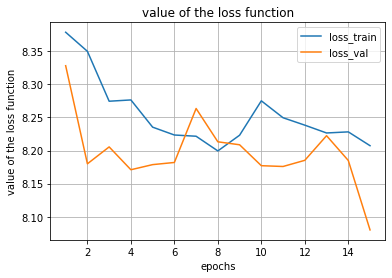

In [109]:
loss = CNN_2_history.history['loss']
loss_val = CNN_2_history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='loss_train')
plt.plot(epochs, loss_val, label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

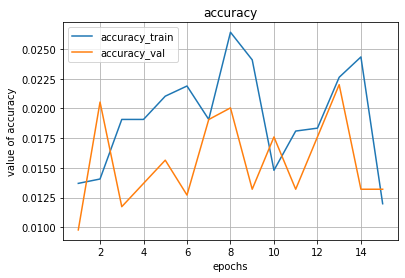

In [110]:
acc = CNN_2_history.history['accuracy']
acc_val = CNN_2_history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, label='accuracy_train')
plt.plot(epochs, acc_val,  label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

### CNN_model_3

In [51]:
CNN_model_3=Sequential()
CNN_model_3.add(Conv2D(filters=64,kernel_size=(3,3),activation='tanh',input_shape=(64,64,1)))
CNN_model_3.add(MaxPool2D(pool_size=(2,2)))
CNN_model_3.add(Dropout(0.05))
CNN_model_3.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(64,64,1)))
CNN_model_3.add(MaxPool2D(pool_size=(2,2)))
CNN_model_3.add(Dropout(0.05))
CNN_model_3.add(Flatten())
CNN_model_3.add(Dense(500, activation = "sigmoid"))
CNN_model_3.add(Dropout(0.05))
CNN_model_3.add(Dense(250, activation = "relu"))
CNN_model_3.add(Dropout(0.05))
CNN_model_3.add(Dense(120, activation = "softmax"))


from keras.preprocessing.image import ImageDataGenerator
data=ImageDataGenerator(height_shift_range=0.1,width_shift_range=0.1,rotation_range=0.1,zoom_range=0.1)

In [52]:
CNN_model_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)       

In [53]:
CNN_model_3.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [55]:
epochs = 10
batch_size = 128


CNN_2_history = CNN_model_3.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))

Epoch 1/10
64/64 [==============================] - 53s 836ms/step - loss: 4.7809 - accuracy: 0.0126 - val_loss: 4.7685 - val_accuracy: 0.0103
Epoch 2/10
64/64 [==============================] - 55s 860ms/step - loss: 4.7135 - accuracy: 0.0181 - val_loss: 4.6628 - val_accuracy: 0.0200
Epoch 3/10
64/64 [==============================] - 58s 907ms/step - loss: 4.5883 - accuracy: 0.0245 - val_loss: 4.5794 - val_accuracy: 0.0230
Epoch 4/10
64/64 [==============================] - 54s 845ms/step - loss: 4.4687 - accuracy: 0.0385 - val_loss: 4.5255 - val_accuracy: 0.0342
Epoch 5/10
64/64 [==============================] - 55s 854ms/step - loss: 4.3486 - accuracy: 0.0580 - val_loss: 4.4853 - val_accuracy: 0.0425
Epoch 6/10
64/64 [==============================] - 53s 832ms/step - loss: 4.1780 - accuracy: 0.0803 - val_loss: 4.4749 - val_accuracy: 0.0406
Epoch 7/10
64/64 [==============================] - 54s 839ms/step - loss: 3.9805 - accuracy: 0.1099 - val_loss: 4.5096 - val_accuracy: 0.0430

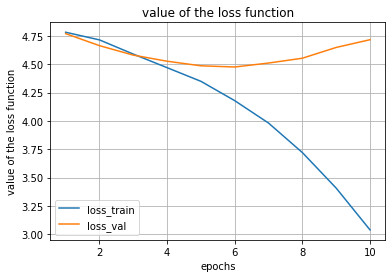

In [56]:
loss = CNN_2_history.history['loss']
loss_val = CNN_2_history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='loss_train')
plt.plot(epochs, loss_val, label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

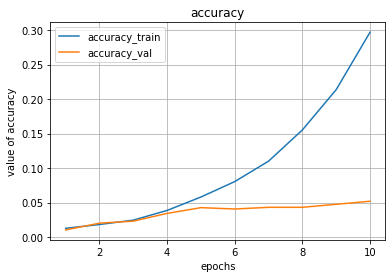

In [57]:
acc = CNN_2_history.history['accuracy']
acc_val = CNN_2_history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, label='accuracy_train')
plt.plot(epochs, acc_val,  label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

Con esto podemos observar de resultado que el comportamiento de la primera y la última red neuronal no es tan bueno. Puesto que a pesar de estar teniendo un incremento en el desempeño de ambas métricas dentro de los datos de entrenamiento, para la parte el set de validación no se ha tenido mejora o incluso a crecido la perdida para el primer caso.

Con respecto al segundo experimento, a pesar de no tener valores de buena magnitud para dichas métricas, siendo la pérdida muy alta y la precisión baja, las métricas del set de entrenamiento y validación se comportan con tendencias similares. Con lo que, en esta ocasión no se encuentra el efecto de overfitting. Observamos que, el mejor desempeño se estaría obteniendo al entrenar el modelo entre los intervalos de 7 a 9 épocas ó de 12 a 14.

Por lo tanto, concluimos que con los modelos generados en estos experimentos no se ha obtenido un modelo que completamente aplicable a la clasificación de razas de perro. Sin embargo, este resultado se puede haber dado debido a la poca cantidad de épocas de entrenamiento, por lo que se recomienda que en futuras ocasiones se implementen los modelos con más memoria computacional y tiempo de entrenado. También podría ser de utilidad ocupar modelos de aprendizaje transferido, entre los cuales sería de utilidad aplicar otras estructuras como lo es ResNet50.